In [50]:
# Package imports and downloads
import pandas as pd
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# Emoji is used to recognize and seperate emojis in the text
!pip install emoji
from emoji import UNICODE_EMOJI

# flair package is used to assign a pos or neg sentiment for each tweet
!pip3 install flair
import flair
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

# Twint is used in the collection of data from twitter
!pip3 install twint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2020-12-07 17:58:59,320 loading file /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt


# Data Collection

DO NOT run unless you are gathering a new/different dataset to use.

In [ ]:
# Python code to get data using twint, outputing to a file called 'output.csv'
import csv, sys, twint

#parse csv file
usernames = []
with open(sys.argv[1]) as csvfile:
#    reader = csv.reader(csvfile, delimiter=",") 
#    next(reader)
    for row in csvfile.readlines():
        usernames.append(row.strip())

print("Loaded %s usernames" % len(usernames))

length = len(usernames)

#start scraping
#create config
c = twint.Config()
c.Store_csv = True
c.Hide_output = True
c.Limit = 100
for cur,username in enumerate(usernames[2323:]):
    c.Username = username
    c.Output = "output/%s.csv" % username
    twint.run.Search(c)
    print("Completed user %d/%d (%f%%)" % (cur+1, length, float(cur+1)/float(length) * 100))

ModuleNotFoundError: ignored

This section of code does not run in python, it runs in the go programming language to combine everything into one csv file.

In [ ]:
# This is code to combine tweets from all users gathered by Twint

package main

import (
	"encoding/csv"
	"log"
	"os"
	"path/filepath"
)

var inputPath = "output/"

func main() {
	//open output
	output, err := os.Create("output2.csv")
	if err != nil {
		log.Fatal(err)
	}
	defer output.Close()
	writer := csv.NewWriter(output)
	str := "id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest"
	output.Write([]byte(str + "\n"))

	//walk input
	err = filepath.Walk(inputPath, func(path string, info os.FileInfo, err error) error {
		if err != nil {
			return err
		}

		if !info.IsDir() {
			input, err := os.Open(path)
			if err != nil {
				return err
			}
			reader := csv.NewReader(input)

			reader.Read() // get rid of header
			records, err := reader.ReadAll()
			if err != nil {
				return err
			}

			err = writer.WriteAll(records)
			if err != nil {
				return err
			}

			input.Close()
		}

		return nil
	})
	if err != nil {
		log.Fatal(err)
	}
}

After the data has been gathered, the two classes are located in two seperate .csv files. Now we need to combine them into one csv file and add a column that tells us if each user is depressed or not depressed. A 1 represents the user is classified as depressed and a 0 represents not depressed.

In [ ]:
# Combine the two depressed/nondepressed csv files into one data csv

df = pd.read_csv('drive/Shareddrives/nlp term project/output.csv')
df = df.drop(['id', 'conversation_id', 'created_at', 'timezone', 'user_id', 
         'place', 'language', 'photos', 'retweet', 'video', 
         'thumbnail', 'near', 'geo', 'source', 'user_rt_id',
         'user_rt', 'retweet_id', 'retweet_date', 'translate',
         'trans_src', 'trans_dest'], axis=1)
df['depressed'] = 1

df2 = pd.read_csv('drive/Shareddrives/nlp term project/output2.csv')
df2 = df2.drop(['id', 'conversation_id', 'created_at', 'timezone', 'user_id', 
         'place', 'language', 'photos', 'retweet', 'video', 
         'thumbnail', 'near', 'geo', 'source', 'user_rt_id',
         'user_rt', 'retweet_id', 'retweet_date', 'translate',
         'trans_src', 'trans_dest'], axis=1)
df2['depressed'] = 0

df.drop(df.tail(147285).index, 
        inplace = True) 


print(len(pd.unique(df2['username'])))
print(len(pd.unique(df['username'])))
print(df['username'])

df = df.append(df2, ignore_index=True)

print()
print()
print(len(pd.unique(df['username'])))
print(df)

df.to_csv('drive/Shareddrives/nlp term project/depr_detect_data.csv', index=False)

# Preprocessing

In [51]:
# Load the full data from the csv format into a dataframe
df = pd.read_csv('drive/Shareddrives/nlp term project/depr_detect_data.csv', lineterminator='\n')
df.head

<bound method NDFrame.head of               date      time  ... depressed sentiment
0       2020-11-17  22:18:28  ...         1        -1
1       2020-11-17  22:15:27  ...         1        -1
2       2020-11-17  22:13:45  ...         1         1
3       2020-11-17  22:10:45  ...         1         1
4       2020-11-17  22:04:12  ...         1         1
...            ...       ...  ...       ...       ...
251680  2016-08-12  23:29:18  ...         0        -1
251681  2020-11-17  17:09:23  ...         0        -1
251682  2020-10-21  04:53:51  ...         0         1
251683  2020-10-20  17:20:31  ...         0        -1
251684  2020-10-14  18:18:12  ...         0        -1

[251685 rows x 17 columns]>

These functions are used to modify the tweet with some standard preprocessing steps used in text classification. Cast to lowercase, substitute any links, substitute user mentions, remove punctuation, remove stopwords, and lemmatize or stem the words.

In [52]:
# search your emoji
def is_emoji(s):
    return s in UNICODE_EMOJI

# add space near your emoji
def add_space(text):
    return ''.join(' ' + char + ' ' if is_emoji(char) else char for char in text).strip()

def preprocess_tweet_text(tweet):
    tweet = tweet.lower()

    tweet = add_space(tweet)

    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", 'LINK', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','USER', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]


    #ps = PorterStemmer()
    #stemmed_words = [ps.stem(w) for w in filtered_words]
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in filtered_words]
    
    return " ".join(lemma_words)

Now store the preprocessed tweet seperately from the original tweet in the dataframe, sometimes the original texts is used to generate a feature so we don't want to modify them.

In [53]:
# Preprocess and store the tweets 
df['processed_tweet'] = [preprocess_tweet_text(tweet) for tweet in df['tweet']]

print(df[:50])

          date  ...                                    processed_tweet
0   2020-11-17  ...                       day done time go home weep 😢
1   2020-11-17  ...  USER good evening sad hear pls give family bes...
2   2020-11-17  ...  USER triggers powerful beth never know take ef...
3   2020-11-17  ...                        USER always welcome helen ☺
4   2020-11-17  ...                                    USER know katie
5   2020-11-17  ...  USER good evening annie trust fyne sooo sorry ...
6   2020-11-17  ...           USER good evening toni men bad enemies 😕
7   2020-11-17  ...  USER good evening chloe agree desperate times ...
8   2020-11-17  ...                              USER chance teeth 😕 😂
9   2020-11-17  ...       USER good night wendy safe peaceful nyte ☺ 😴
10  2020-11-17  ...  USER gudnyt michele lily safe peaceful nyte du...
11  2020-11-17  ...  USER dmd sorry hear gosh things becoming impos...
12  2020-11-17  ...                   USER legend many reasons katie 😍
13  20

# Feature Extraction

This part uses the flair package to assign a positive or negative sentiment label to each tweet in the dataset and then saves it to the csv file the data is stored in so that this does not have to be repeated every time.

DO NOT run unless you are spending the time to reassign sentiment value to every tweet in the dataset.

In [ ]:
# Get sentiment using the Flair python package

global counter
counter = 0
def get_sentiment(sentence):
  global counter
  counter = counter + 1
  if counter % 10000 == 0:
    print(counter)
  if sentence == '':
    return 1
  s = flair.data.Sentence(sentence)
  flair_sentiment.predict(s)
  value = s.labels[0].to_dict()['value'] 
  if value == 'POSITIVE':
    return 1
  else:
    return -1

sentiments = [get_sentiment(tweet) for tweet in df['tweet']]
df['sentiment'] = sentiments

#df.to_csv('drive/Shareddrives/nlp term project/depr_detect_data.csv', index=False)


Now we start the feature extraction and store all of the features in a dataframe matrix.

In [54]:
# Create a dataframe to store the feature matrix
features = pd.DataFrame()

# Shows the count of unique usernames in the data
usernames = pd.unique(df['username'])
print(len(usernames))

3000


In [55]:
# Add the depression class assigned for each user as well as the proportions of 
# each users posts that are positive and negative 
depression_list = []
positive_list = []
negative_list = []

for username in usernames:
  depression_list.append(df[df.username == username].iloc[0]['depressed'])
  positive_list.append(len(df[(df['username'] == username) & (df['sentiment'] == 1)]) / 
                       len(df[df['username'] == username]))
  negative_list.append(len(df[(df['username'] == username) & (df['sentiment'] == -1)]) /
                       len(df[df['username'] == username]))

In [56]:
# Check that the features were properly added to the dataframe
features['depressed'] = depression_list
features['positive_prop'] = positive_list
features['negative_prop'] = negative_list

print(features)

print("Average proportion of positive tweets per depressed user:", features[features['depressed']==1].positive_prop.mean())
print("Average proportion of positive tweets per nondepressed user:", features[features['depressed']==0].positive_prop.mean())
print("Average proportion of negative tweets per depressed user:", features[features['depressed']==1].negative_prop.mean())
print("Average proportion of negative tweets per nondepressed user:", features[features['depressed']==0].negative_prop.mean())

      depressed  positive_prop  negative_prop
0             1       0.520000       0.480000
1             1       0.350000       0.650000
2             1       0.370000       0.630000
3             1       0.390000       0.610000
4             1       0.600000       0.400000
...         ...            ...            ...
2995          0       0.437500       0.562500
2996          0       0.532468       0.467532
2997          0       0.452381       0.547619
2998          0       0.300000       0.700000
2999          0       0.250000       0.750000

[3000 rows x 3 columns]
Average proportion of positive tweets per depressed user: 0.40642929006554945
Average proportion of positive tweets per nondepressed user: 0.457781980778798
Average proportion of negative tweets per depressed user: 0.5935707099344507
Average proportion of negative tweets per nondepressed user: 0.5422180192212013


In [57]:
# Get the average swear words used per post for each user
swears = "fuck|shit|bitch|bullshit|effing|damn|goddamn|ass|bastard|dick"

# Total count of times a swear is in all tweets
print(df.processed_tweet.str.count(swears).sum())

swear_avgs = []
for username in usernames:
  swear_avgs.append(df[df['username'] == username].processed_tweet.str.count(swears).sum() / 
                    len(df[df['username'] == username]))

17986


In [58]:
# Check that the feature was properly added to the dataframe
features['swear_avgs'] = swear_avgs
print(features)

# Get the overall average swears per depressed or nondepressed classes
dep_swears = df[df['depressed'] == 1].processed_tweet.str.count(swears).sum() / \
              len(df[df['depressed'] == 1])
nondep_swears = df[df['depressed'] == 0].processed_tweet.str.count(swears).sum() / \
              len(df[df['depressed'] == 0])

print('Average swear word count per tweet for all depressed users:', dep_swears)
print('Average swear word count per tweet for all nondepressed users:', nondep_swears)

      depressed  positive_prop  negative_prop  swear_avgs
0             1       0.520000       0.480000    0.000000
1             1       0.350000       0.650000    0.050000
2             1       0.370000       0.630000    0.060000
3             1       0.390000       0.610000    0.050000
4             1       0.600000       0.400000    0.000000
...         ...            ...            ...         ...
2995          0       0.437500       0.562500    0.000000
2996          0       0.532468       0.467532    0.038961
2997          0       0.452381       0.547619    0.035714
2998          0       0.300000       0.700000    0.010000
2999          0       0.250000       0.750000    0.000000

[3000 rows x 4 columns]
Average swear word count per tweet for all depressed users: 0.0752183785227728
Average swear word count per tweet for all nondepressed users: 0.060564253604092386


This feature (Avg word count) ended up lowering the accuracy of the model so for now we decided to leave it out.

In [59]:
# Get a word count for each tweet in the data
df['word_count'] = [len(tweet.split()) for tweet in df['tweet']]

# Calculate the average word count for all the tweets a user has posted
word_avgs = []
for username in usernames:
  word_avgs.append(df[df['username'] == username].word_count.sum() /
                   len(df[df['username'] == username]))

In [60]:
# Check that the feature is properly added to the dataframe
features['word_count_avg'] = word_avgs
print(features)

# Calculate overall averages for each class
print('Average word count per tweet for depressed users:', df[df['depressed'] == 1]['word_count'].mean())
print('Average word count per tweet for nondepressed users:', df[df['depressed'] == 0]['word_count'].mean())

# Ended up dropping this feature for now
features = features.drop('word_count_avg', axis=1)

      depressed  positive_prop  negative_prop  swear_avgs  word_count_avg
0             1       0.520000       0.480000    0.000000       13.700000
1             1       0.350000       0.650000    0.050000        8.050000
2             1       0.370000       0.630000    0.060000        9.820000
3             1       0.390000       0.610000    0.050000        8.260000
4             1       0.600000       0.400000    0.000000       15.970000
...         ...            ...            ...         ...             ...
2995          0       0.437500       0.562500    0.000000       12.687500
2996          0       0.532468       0.467532    0.038961        9.467532
2997          0       0.452381       0.547619    0.035714       14.523810
2998          0       0.300000       0.700000    0.010000       13.700000
2999          0       0.250000       0.750000    0.000000        3.000000

[3000 rows x 5 columns]
Average word count per tweet for depressed users: 15.275453452651263
Average word count

In [61]:
# Terms that could be used to describe symptoms in depression
symptoms = "anxiety|tired|tire|suicide|cry|sleep|sad|anger|frustrate|death|"\
           "irrit|feeling down|nervous|anxious|insomnia|cant sleep|hopeless|"\
           "dont care|stress|escape|procrastinate|pain|hurt|tear|angry|headache|" \
           "death|dead|worthless|restless|empty|no energy|not hungry|bored|failure|" \
           "hate|concentrate|memory|issues|nightmare|unhappy|miserable|" \
           "stress|no energy|ache|fail|help"

# Total count of times a symptom is mentioned in all tweets
print(df.processed_tweet.str.count(symptoms).sum())

# Calculate the average number of symptom mentions amongst all of a user's tweets
symptom_avgs = []
for username in usernames:
  symptom_avgs.append(df[df['username'] == username].processed_tweet.str.count(symptoms).sum() / 
                    len(df[df['username'] == username]))

26976


In [62]:
# Check that the feature is properly added
features['symptom_avgs'] = symptom_avgs
print(features)

# Get the overall averages of symptom mentions
dep_sym = df[df['depressed'] == 1].processed_tweet.str.count(symptoms).sum() / \
              len(df[df['depressed'] == 1])
nondep_sym = df[df['depressed'] == 0].processed_tweet.str.count(symptoms).sum() / \
              len(df[df['depressed'] == 0])

print('Symptom mention average per tweet for depressed users:', dep_sym)
print('Symptom mention average per tweet for nondepressed users:', nondep_sym)

      depressed  positive_prop  negative_prop  swear_avgs  symptom_avgs
0             1       0.520000       0.480000    0.000000      0.050000
1             1       0.350000       0.650000    0.050000      0.130000
2             1       0.370000       0.630000    0.060000      0.090000
3             1       0.390000       0.610000    0.050000      0.030000
4             1       0.600000       0.400000    0.000000      0.050000
...         ...            ...            ...         ...           ...
2995          0       0.437500       0.562500    0.000000      0.000000
2996          0       0.532468       0.467532    0.038961      0.090909
2997          0       0.452381       0.547619    0.035714      0.095238
2998          0       0.300000       0.700000    0.010000      0.090000
2999          0       0.250000       0.750000    0.000000      0.000000

[3000 rows x 5 columns]
Symptom mention average per tweet for depressed users: 0.12158675036730332
Symptom mention average per tweet fo

In [63]:
thirds = "he|him|his|himself|she|her|herself|it|its|itself|oneself|they|them|their|themselves"

# Show the number of times a third person pronoun used among all tweets
print(df.processed_tweet.str.count(thirds).sum())

# Calculate the average number of 3rd person pronouns amongst all of a user's tweets
third_person = []
for username in usernames:
  third_person.append(df[df['username'] == username].processed_tweet.str.count(thirds).sum() / 
                    len(df[df['username'] == username]))

109999


In [64]:
features['third_person'] = third_person
print(features)

# Get the overall averages of third person usages
dep_third = df[df['depressed'] == 1].processed_tweet.str.count(thirds).sum() / \
              len(df[df['depressed'] == 1])
nondep_third = df[df['depressed'] == 0].processed_tweet.str.count(thirds).sum() / \
              len(df[df['depressed'] == 0])

print('Average number of third person pronouns per tweet for depressed users:', dep_third)
print('Average number of third person pronouns per tweet for nondepressed users:', nondep_third)

      depressed  positive_prop  ...  symptom_avgs  third_person
0             1       0.520000  ...      0.050000      0.220000
1             1       0.350000  ...      0.130000      0.150000
2             1       0.370000  ...      0.090000      0.240000
3             1       0.390000  ...      0.030000      0.170000
4             1       0.600000  ...      0.050000      0.290000
...         ...            ...  ...           ...           ...
2995          0       0.437500  ...      0.000000      0.750000
2996          0       0.532468  ...      0.090909      0.311688
2997          0       0.452381  ...      0.095238      0.476190
2998          0       0.300000  ...      0.090000      0.410000
2999          0       0.250000  ...      0.000000      0.000000

[3000 rows x 6 columns]
Average number of third person pronouns per tweet for depressed users: 0.46877521036463204
Average number of third person pronouns per tweet for nondepressed users: 0.34500077507363197


In [65]:
firsts = "I|me|my|mine|myself|we|us|our|ours|ourself"

# Show the number of times a first person pronoun used among all tweets
print(df.processed_tweet.str.count(firsts).sum())

# Calculate the average number of 1st person pronouns amongst all of a user's tweets
first_person = []
for username in usernames:
  first_person.append(df[df['username'] == username].processed_tweet.str.count(firsts).sum() / 
                    len(df[df['username'] == username]))

239536


In [66]:
features['first_person'] = symptom_avgs
print(features)

# Get the overall averages of first person usages
dep_first = df[df['depressed'] == 1].processed_tweet.str.count(firsts).sum() / \
              len(df[df['depressed'] == 1])
nondep_first = df[df['depressed'] == 0].processed_tweet.str.count(firsts).sum() / \
              len(df[df['depressed'] == 0])

print('Average number of first person pronouns per tweet for depressed users:', dep_first)
print('Average number of first person pronouns per tweet for nondepressed users:', nondep_first)

      depressed  positive_prop  ...  third_person  first_person
0             1       0.520000  ...      0.220000      0.050000
1             1       0.350000  ...      0.150000      0.130000
2             1       0.370000  ...      0.240000      0.090000
3             1       0.390000  ...      0.170000      0.030000
4             1       0.600000  ...      0.290000      0.050000
...         ...            ...  ...           ...           ...
2995          0       0.437500  ...      0.750000      0.000000
2996          0       0.532468  ...      0.311688      0.090909
2997          0       0.452381  ...      0.476190      0.095238
2998          0       0.300000  ...      0.410000      0.090000
2999          0       0.250000  ...      0.000000      0.000000

[3000 rows x 7 columns]
Average number of first person pronouns per tweet for depressed users: 1.0213383197542407
Average number of first person pronouns per tweet for nondepressed users: 0.7497597271740816


In [67]:
time_class = []
# Find the most active time period for each user and store it as a value for each
for username in usernames:
  time_counts = [0,0,0,0,0,0]
  times = df[df['username'] == username].time.str[:2]
  for time in times:
    time = int(time)
    if time < 4:
      time_counts[0] += 1
    elif 4 <= time < 8:
      time_counts[1] += 1
    elif 8 <= time < 12:
      time_counts[2] += 1
    elif 12 <= time < 16:
      time_counts[3] += 1
    elif 16 <= time < 20:
      time_counts[4] += 1
    else:
      time_counts[5] += 1
  time_class.append(time_counts.index(max(time_counts)))

In [68]:
# Check the feature is properly added
features['active_time'] = time_class
print(features)

# Find the most frequent time period for users in each class
print('Most active time period to post for depressed users:', 
      features[features['depressed'] == 1]['active_time'].mode())
print('Most active time period to post for nondepressed users:',
      features[features['depressed'] == 0]['active_time'].mode())

# Since this feature has the same most active time period and does not affect model
# accuracy, we can remove it for now
features = features.drop('active_time', axis=1)

      depressed  positive_prop  ...  first_person  active_time
0             1       0.520000  ...      0.050000            5
1             1       0.350000  ...      0.130000            0
2             1       0.370000  ...      0.090000            0
3             1       0.390000  ...      0.030000            2
4             1       0.600000  ...      0.050000            5
...         ...            ...  ...           ...          ...
2995          0       0.437500  ...      0.000000            4
2996          0       0.532468  ...      0.090909            0
2997          0       0.452381  ...      0.095238            4
2998          0       0.300000  ...      0.090000            4
2999          0       0.250000  ...      0.000000            4

[3000 rows x 8 columns]
Most active time period to post for depressed users: 0    4
dtype: int64
Most active time period to post for nondepressed users: 0    4
dtype: int64


In [69]:
from datetime import date

# Calculate the average time in days between each post for every user
avg_days = []
for username in usernames:
  dates = df[df['username'] == username].date.str[:]
  dates.reset_index(inplace=True, drop=True)
  d0 = date(1,1,1)
  #print(dates)
  total = 0
  for i in range(len(dates)):
    tweet_date = dates[i].split('-')
    year = int(tweet_date[0])
    month = int(tweet_date[1])
    day = int(tweet_date[2])
    if i != 0:
      d1 = date(year, month, day)
      delta = d0 - d1
      total += delta.days
      d0 = date(year, month, day)
    else:
      d0 = date(year, month, day)
  avg_days.append(total / len(df[df['username'] == username]))


In [70]:
# Check the feature is properly added
features['avg_days'] = avg_days
print(features)

# Calculate the average number of days between tweets for each class
print('Average number of days between posts for depressed users:',
      features[features['depressed'] == 1]['avg_days'].mean())
print('Average number of days between posts for nondepressed users:',
      features[features['depressed'] == 0]['avg_days'].mean())

      depressed  positive_prop  ...  first_person   avg_days
0             1       0.520000  ...      0.050000   0.030000
1             1       0.350000  ...      0.130000   2.740000
2             1       0.370000  ...      0.090000   0.250000
3             1       0.390000  ...      0.030000   0.480000
4             1       0.600000  ...      0.050000   2.620000
...         ...            ...  ...           ...        ...
2995          0       0.437500  ...      0.000000  10.750000
2996          0       0.532468  ...      0.090909   4.688312
2997          0       0.452381  ...      0.095238   4.904762
2998          0       0.300000  ...      0.090000  14.750000
2999          0       0.250000  ...      0.000000   8.500000

[3000 rows x 8 columns]
Average number of days between posts for depressed users: 3.773596565507119
Average number of days between posts for nondepressed users: 17.45462378761607


From expirimenting with the model and different features, we know that average word count and most active time period do not improve our model accuracy so we choose to use everything but those two for our models.

# Model Creation

Now that we have our features, we can create models and test their accuracy.

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier


# Split the feature dataframe into training and test data
train, test = train_test_split(features, test_size=0.2, random_state=50)

# Create and display the X and Y sets to use for training and validation
Xtrain = train.drop('depressed', axis=1)
Ytrain = train['depressed'].values.tolist()

Xtest = test.drop('depressed', axis=1)
Ytest = test['depressed'].values.tolist()

print(Xtrain)
print(Ytrain)

      positive_prop  negative_prop  ...  first_person   avg_days
1551       0.422535       0.577465  ...      0.056338  20.492958
2568       0.470000       0.530000  ...      0.050000   0.930000
1751       0.469072       0.530928  ...      0.087629   1.002577
2851       1.000000       0.000000  ...      1.000000   0.000000
1643       0.260000       0.740000  ...      0.060000   0.520000
...             ...            ...  ...           ...        ...
2014       0.571429       0.428571  ...      0.000000   7.428571
2157       0.590000       0.410000  ...      0.040000  25.650000
1931       0.833333       0.166667  ...      0.000000   0.333333
1504       0.777778       0.222222  ...      0.000000  18.888889
1712       0.800000       0.200000  ...      0.000000   0.114286

[2400 rows x 7 columns]
[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,

In [72]:
# Create the random forest classifier from sklearn and fit 
# it to the data, using default values as tuning lowered accuracy

clf = RandomForestClassifier(random_state=15)

clf.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=15, verbose=0,
                       warm_start=False)

              precision    recall  f1-score   support

           0       0.85      0.76      0.80       309
           1       0.77      0.85      0.81       291

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600

Accuracy: 0.8066666666666666

[[236  73]
 [ 43 248]]



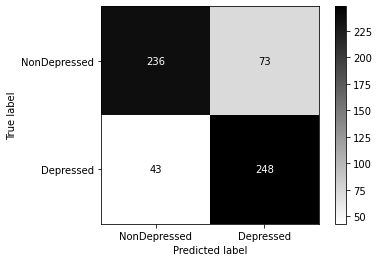

In [73]:
# Output various evaluation metrics for the random forest classifier
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

predictions = clf.predict(Xtest)
print(classification_report(Ytest, predictions))
print("Accuracy:", accuracy_score(Ytest, predictions))
print()
print(confusion_matrix(Ytest, predictions))
print()

# display the confusion matrix as a proper plot
disp = plot_confusion_matrix(clf, Xtest, Ytest, 
                             display_labels=['NonDepressed', 'Depressed'],
                             cmap=plt.cm.binary, values_format='')

In [74]:
# Create a neural network model on the features (from sklearn), it holds two layers
# the second the same size as the number of features used
clf2 = MLPClassifier(random_state=15, alpha=0.00001, hidden_layer_sizes=(100,7))

clf2.fit(Xtrain, Ytrain)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 7), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=15, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       309
           1       0.76      0.82      0.79       291

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.79      0.78      0.78       600

Accuracy: 0.7833333333333333

[[232  77]
 [ 53 238]]



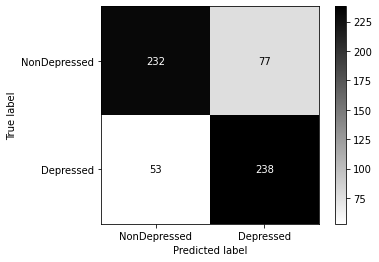

In [75]:
# Output various evaluation metrics for the NN classifier
predictions = clf2.predict(Xtest)
print(classification_report(Ytest, predictions))
print("Accuracy:", accuracy_score(Ytest, predictions))
print()
print(confusion_matrix(Ytest, predictions))
print()

# display the confusion matrix as a proper plot
disp = plot_confusion_matrix(clf2, Xtest, Ytest, 
                             display_labels=['NonDepressed', 'Depressed'],
                             cmap=plt.cm.binary, values_format='')